In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import  torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.optim.lr_scheduler import LinearLR

In [2]:
transformation = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transformation)

100%|████████████████████████████| 9912422/9912422 [00:08<00:00, 1173486.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 14156327.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|█████████████████████████████| 1648877/1648877 [00:02<00:00, 797103.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 6223629.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
dataloader = DataLoader(dataset, batch_size=64, drop_last=True)

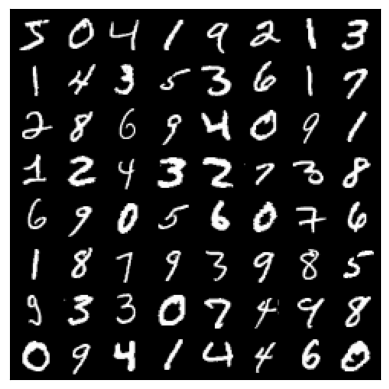

In [4]:
images, labels = next(iter(dataloader))

def show_image_grid(images: torch.Tensor, ncol: int):
    image_grid = make_grid(images, ncol)     # Make images into a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last
    image_grid = image_grid.numpy()    # Convert into Numpy

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()


show_image_grid(images, ncol=8)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def generate_images(self):
        z = torch.randn(64, 100)
        output = self.generator(z)
        generated_images = output.reshape(64, 1, 28, 28)

        return generated_images

    def forward(self, x):
        x = self.generator(x)
        return x

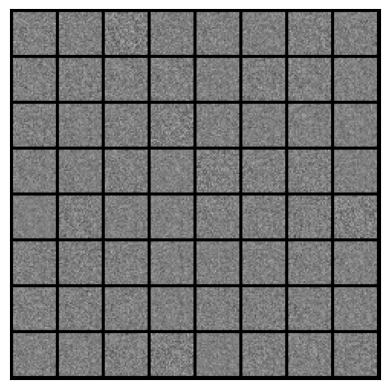

In [6]:
generator_model = Generator()
generated_images = generator_model.generate_images()

show_image_grid(generated_images, ncol=8)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = self.discriminator(x)
        return x

In [17]:
discriminator_model = Discriminator()
discriminator_model.eval()
with torch.no_grad():
    predictions = discriminator_model(generated_images.reshape(-1, 784))
predictions

tensor([[0.1065],
        [0.1083],
        [0.0895],
        [0.1007],
        [0.1195],
        [0.0954],
        [0.1195],
        [0.1063],
        [0.1124],
        [0.1152],
        [0.1061],
        [0.0868],
        [0.1010],
        [0.0894],
        [0.1012],
        [0.1016],
        [0.0949],
        [0.1311],
        [0.1010],
        [0.1152],
        [0.0922],
        [0.0875],
        [0.1121],
        [0.0973],
        [0.1256],
        [0.1049],
        [0.1124],
        [0.0884],
        [0.0966],
        [0.1015],
        [0.1117],
        [0.1213],
        [0.1191],
        [0.0890],
        [0.1050],
        [0.1001],
        [0.0951],
        [0.1098],
        [0.1131],
        [0.1199],
        [0.1080],
        [0.0877],
        [0.1079],
        [0.1091],
        [0.1102],
        [0.0945],
        [0.0948],
        [0.1095],
        [0.1261],
        [0.0993],
        [0.1081],
        [0.0934],
        [0.1209],
        [0.1095],
        [0.1063],
        [0

In [9]:
real_targets = torch.ones(64, 1)
fake_targets = torch.zeros(64, 1)

In [10]:
def calculate_loss(discriminator, images: torch.Tensor, targets: torch.Tensor):
    prediction = discriminator(images.reshape(-1, 784))
    loss = F.binary_cross_entropy_with_logits(prediction, targets)
    return loss

calculate_loss(discriminator_model, generated_images, real_targets)

tensor(0.7090, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# Training Discriminator Networks

In [18]:
d_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1.0e-4, weight_decay=1.0e-4)
d_scheduler = LinearLR(d_optimizer, start_factor=1.0, end_factor=0.3, total_iters=30)

### Before Training

In [19]:
for images, _ in dataloader:
    # compare the sigmoid output from discriminator with real_ragets
    d_loss = calculate_loss(discriminator_model, images, real_targets)
    print(d_loss)

    # Loss with generated image inputs and fake_targets as labels
    generated_images = generator_model.generate_images()
    d_loss += calculate_loss(discriminator_model, generated_images, fake_targets)
    print(d_loss)
    break

tensor(0.6372, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3842, grad_fn=<AddBackward0>)


In [20]:
discriminator_model.train()
generator_model.eval()

n_epochs = 1

for epoch in range(n_epochs):

    train_loss = 0.0
    for images, _ in dataloader:
        # compare the sigmoid output from discriminator with real_ragets
        d_loss = calculate_loss(discriminator_model, images, real_targets)

        # Loss with generated image inputs and fake_targets as labels
        generated_images = generator_model.generate_images()
        d_loss += calculate_loss(discriminator_model, generated_images, fake_targets)

        # update weights
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        train_loss = d_loss * images.size(0)
    
    print(f"Epoch [{epoch} / {n_epochs}], train_loss: {train_loss / len(dataloader)}")

Epoch [0 / 1], train_loss: 0.00034718384267762303


### After Training

In [21]:
for images, _ in dataloader:
    # compare the sigmoid output from discriminator with real_ragets
    d_loss = calculate_loss(discriminator_model, images, real_targets)
    print(d_loss)

    # Loss with generated image inputs and fake_targets as labels
    generated_images = generator_model.generate_images()
    d_loss += calculate_loss(discriminator_model, generated_images, fake_targets)
    print(d_loss)
    break

tensor(0.0032, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0034, grad_fn=<AddBackward0>)


# Training Generator Networks

In [22]:
g_optimizer = torch.optim.Adam(generator_model.parameters(), lr=1.0e-4, weight_decay=1.0e-4)
g_scheduler = LinearLR(g_optimizer, start_factor=1.0, end_factor=0.3, total_iters=30)

### Before Training

In [23]:
for images, _ in dataloader:
    # Loss with generated image inputs and real_tragets as labels
    generated_images = generator_model.generate_images()
    d_loss = calculate_loss(discriminator_model, generated_images, real_targets)
    print(d_loss)
    break

tensor(8.7056, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [25]:
# On training mode
generator_model.train()

# On eval mode
discriminator_model.eval()

for epoch in range(5):

    train_loss = 0.0
    for images, labels in dataloader:
        # Loss with generated image inputs and real_targets as labels
        generated_images = generator_model.generate_images()
        g_loss = calculate_loss(discriminator_model, generated_images, real_targets)

        # Optimizer updates the generator parameters
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
        train_loss = g_loss * images.size(0)
    
    print(f"Epoch [{epoch} / {n_epochs}], train_loss: {train_loss / len(dataloader)}")

Epoch [0 / 1], train_loss: 0.0007737281266599894
Epoch [1 / 1], train_loss: 0.0001580133830429986
Epoch [2 / 1], train_loss: 7.146620919229463e-05
Epoch [3 / 1], train_loss: 4.730199361802079e-05
Epoch [4 / 1], train_loss: 4.3918975279666483e-05


### After Training

In [26]:
for images, _ in dataloader:
    # Loss with generated image inputs and real_tragets as labels
    generated_images = generator_model.generate_images()
    d_loss = calculate_loss(discriminator_model, generated_images, real_targets)
    print(d_loss)
    break

tensor(0.0007, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


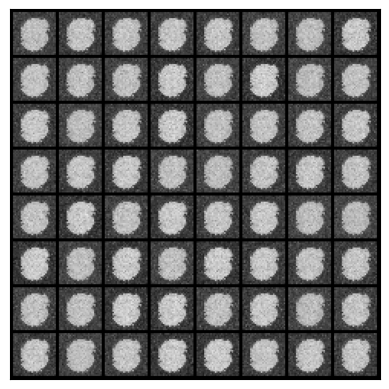

In [27]:
generated_images = generator_model.generate_images()

show_image_grid(generated_images, ncol=8)